In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Financial/Brent monthly crude oil spot price.csv')
df.head()

,Brent crude oil spot price,Monthly (dollars per barrel)
0,1990 01,21.251
1,1990 02,19.813
2,1990 03,18.387
3,1990 04,16.612
4,1990 05,16.352


In [4]:
df.tail()

,Brent crude oil spot price,Monthly (dollars per barrel)
391,2022 08,60.0
392,2022 09,60.0
393,2022 10,61.0
394,2022 11,61.0
395,2022 12,61.0


In [5]:
df.shape

(396, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Brent crude oil spot price     396 non-null    object 
 1    Monthly (dollars per barrel)  396 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [7]:
time = pd.date_range(start='1/1/1990',periods=396,freq='M')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Brent crude oil spot price'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [8]:
df.columns=['dollars_per_barrel']

In [9]:
df.head()

,dollars_per_barrel
time_stamp,
1990-01-31,21.251
1990-02-28,19.813
1990-03-31,18.387
1990-04-30,16.612
1990-05-31,16.352


In [10]:
df.tail()

,dollars_per_barrel
time_stamp,
2022-08-31,60.0
2022-09-30,60.0
2022-10-31,61.0
2022-11-30,61.0
2022-12-31,61.0


In [11]:
plt.rcParams['figure.figsize'] = [15,8]

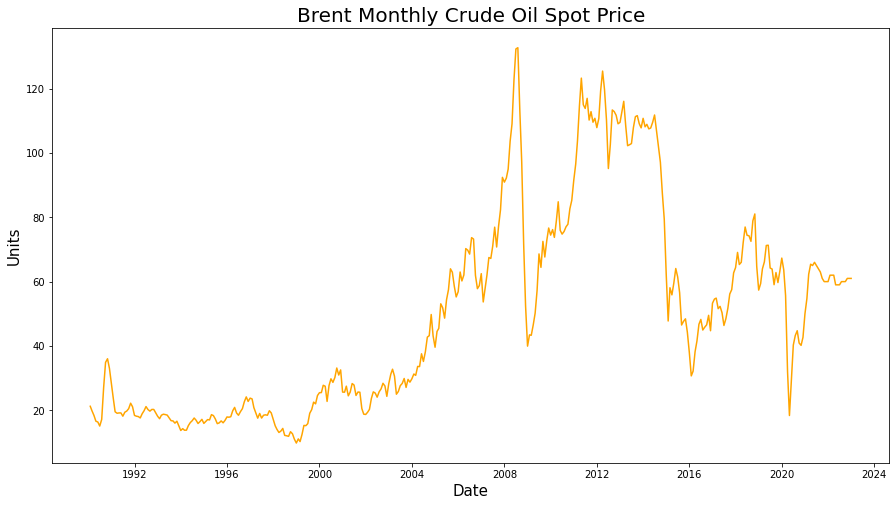

In [12]:
plt.plot(df,color='orange')
plt.title('Brent Monthly Crude Oil Spot Price',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [13]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [14]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['dollars_per_barrel'] = df['dollars_per_barrel'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [15]:
#Split data set into testing dataset and train dataset
train_size = 345
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(341, 1, 4)
(341,)
(47, 1, 4)
(47,)


In [17]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 26.4 MB/s 


In [18]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('lstm_layer',min_value=4,max_value=128,step=4), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=4,max_value=128,step=4),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
lstm_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 4, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 4, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=33,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 18s]
val_mape: 18.40593910217285

Best val_mape So Far: 6.525504112243652
Total elapsed time: 00h 03m 21s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
lstm_layer: 20
first_recurrent_dropout: 0.4
dense_layer: 116
Dropout_rate: 0.30000000000000004
learning_rate: 0.0054746607168951154
Score: 6.525504112243652
Trial summary
Hyperparameters:
lstm_layer: 36
first_recurrent_dropout: 0.4
dense_layer: 100
Dropout_rate: 0.5
learning_rate: 0.016888094935968035
Score: 6.724810600280762
Trial summary
Hyperparameters:
lstm_layer: 24
first_recurrent_dropout: 0.6
dense_layer: 88
Dropout_rate: 0.1
learning_rate: 0.006163966497492903
Score: 6.73318338394165
Trial summary
Hyperparameters:
lstm_layer: 84
first_recurrent_dropout: 0.6
dense_layer: 128
Dropout_rate: 0.4
learning_rate: 0.001164799411133899
Score: 6.93251895904541
Trial summary
Hyperparameters:
lstm_layer: 100
first_recurrent_dropout: 0.2
dense_layer: 124
Dropout_rate: 0.4
learning_rate: 0.0056446918868211585
Score: 6.969294548034668
Trial summary
Hype

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2000      
                                                                 
 dense (Dense)               (None, 116)               2436      
                                                                 
 dropout (Dropout)           (None, 116)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 117       
                                                                 
Total params: 4,553
Trainable params: 4,553
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

In [20]:
model = Sequential()
model.add(LSTM(128,activation='relu',input_dim = 4))
model.add(Dense(116,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.00014746607168951154)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 33, epochs = 700)

Epoch 1/700
11/11 [==============================] - 3s 34ms/step - loss: 99.9151 - mape: 99.9151 - val_loss: 98.1396 - val_mape: 98.1396
Epoch 2/700
11/11 [==============================] - 0s 6ms/step - loss: 94.6123 - mape: 94.6123 - val_loss: 94.2025 - val_mape: 94.2025
Epoch 3/700
11/11 [==============================] - 0s 6ms/step - loss: 90.4236 - mape: 90.4236 - val_loss: 90.8013 - val_mape: 90.8013
Epoch 4/700
11/11 [==============================] - 0s 6ms/step - loss: 86.3382 - mape: 86.3382 - val_loss: 87.5662 - val_mape: 87.5662
Epoch 5/700
11/11 [==============================] - 0s 8ms/step - loss: 82.0261 - mape: 82.0261 - val_loss: 84.2148 - val_mape: 84.2148
Epoch 6/700
11/11 [==============================] - 0s 6ms/step - loss: 77.3337 - mape: 77.3337 - val_loss: 80.5523 - val_mape: 80.5523
Epoch 7/700
11/11 [==============================] - 0s 7ms/step - loss: 72.2930 - mape: 72.2930 - val_loss: 76.4334 - val_mape: 76.4334
Epoch 8/700
11/11 [=====================

In [21]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [22]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 5.79 
Test MAPE : 7.93 


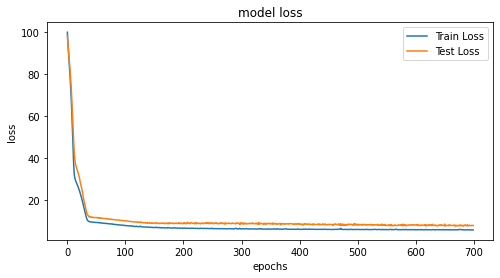

In [23]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [25]:
import seaborn as sns

In [24]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(341,388)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

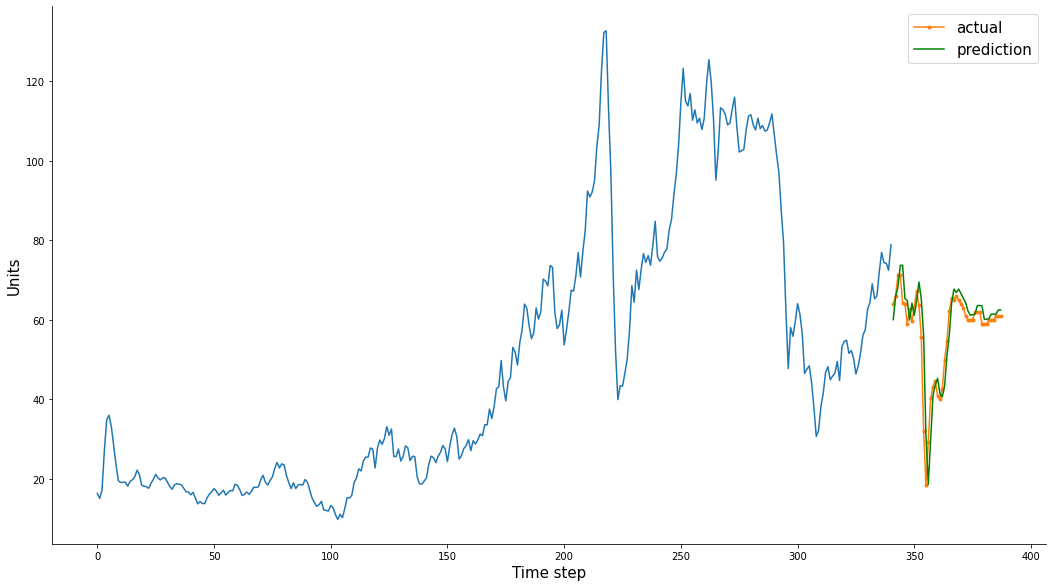

In [26]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)